In [33]:
!pip install pandas numpy matplotlib seaborn

In [34]:
!pip install vaderSentiment

In [35]:
!pip install opencage

In [36]:
import requests
import pandas as pd
from opencage.geocoder import OpenCageGeocode
import folium
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns


In [37]:
# Define the API keys and endpoint
api_keys = ['fcc662035f5c468489522641cd746414', '292537924a7b44ab90d1baede74c54fa', 'e3787bc56ae04d05a028a1c295f4f198']
url = 'https://newsapi.org/v2/everything'

# Initialize an empty list to store articles
articles = []

# Parameters for the API request
for api_key in api_keys:
    params = {
        'q': 'Trump',
        'pageSize': 100,  # Maximum number of results per page
        'apiKey': api_key,
    }

    # Fetch articles for the current API key
    response = requests.get(url, params=params)
    data = response.json()

    # Check if the request was successful
    if response.status_code == 200:
        articles.extend(data['articles'])
        print(f"Fetched {len(data['articles'])} articles using API key {api_key}")
    else:
        print(f"Failed to fetch articles using API key {api_key}: {data.get('message', 'Unknown error')}")

    # Stop fetching if we have collected at least 300 articles
    if len(articles) >= 300:
        break

# Convert the articles to a DataFrame
df = pd.DataFrame(articles)

# Save the DataFrame to a CSV file
df.to_csv('trump_news.csv', index=False)
print(f"Saved {len(articles)} articles to trump_news.csv")


Fetched 100 articles using API key fcc662035f5c468489522641cd746414
Fetched 100 articles using API key 292537924a7b44ab90d1baede74c54fa
Fetched 100 articles using API key e3787bc56ae04d05a028a1c295f4f198
Saved 300 articles to trump_news.csv


In [38]:
# OpenCage API key
opencage_api_key = 'ebe09572f8f5486aac4b55ac52b29460'  # Replace with your actual OpenCage API key
geocoder = OpenCageGeocode(opencage_api_key)

# Load the news articles from the CSV file
df = pd.read_csv('/content/trump_news.csv')

# Check the columns in the DataFrame
print(df.columns)

# Extract the 'source.name' column correctly
df['source_name'] = df['source'].apply(lambda x: eval(x)['name'] if pd.notna(x) else None)

# Function to get latitude and longitude for a location
def get_lat_long(location):
    result = geocoder.geocode(location)
    if result and len(result):
        return result[0]['geometry']['lat'], result[0]['geometry']['lng']
    return None, None

# Add latitude and longitude columns to the DataFrame
df['latitude'] = df['source_name'].apply(lambda loc: get_lat_long(loc)[0])
df['longitude'] = df['source_name'].apply(lambda loc: get_lat_long(loc)[1])

# Save the geolocated data to a new CSV file
df.to_csv('trump_news_geolocated.csv', index=False)
print(f"Geolocated data saved to trump_news_geolocated.csv")


Index(['source', 'author', 'title', 'description', 'url', 'urlToImage',
       'publishedAt', 'content'],
      dtype='object')
Geolocated data saved to trump_news_geolocated.csv


Application of the fetched Data on a map in order to visualize the data.

In [39]:
# Load the geolocated data from the CSV file
df = pd.read_csv('/content/trump_news_geolocated.csv')

# Initialize a folium map centered around the mean location
map_center = [df['latitude'].mean(), df['longitude'].mean()]
news_map = folium.Map(location=map_center, zoom_start=2)

# Add markers to the map
for _, row in df.iterrows():
    if not pd.isna(row['latitude']) and not pd.isna(row['longitude']):
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=row['title'],
            tooltip=row['source_name']
        ).add_to(news_map)

# Save the map to an HTML file
news_map.save('trump_news_map.html')
print(f"Interactive map saved to trump_news_map.html")

# Display the map in the notebook
news_map

Interactive map saved to trump_news_map.html


Applying Sentiment Analysis on the data we have fetched from the News API

In [32]:
# Load the geolocated data from the CSV file
df = pd.read_csv('/content/trump_news_geolocated.csv')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment category
def get_sentiment_category(score):
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to the article descriptions
df['sentiment'] = df['description'].apply(lambda desc: get_sentiment_category(analyzer.polarity_scores(desc) if pd.notna(desc) else {'compound': 0}))

# Save the sentiment analysis results to a new CSV file
df.to_csv('trump_news_sentiment.csv', index=False)
print(f"Sentiment analysis results saved to trump_news_sentiment.csv")


Sentiment analysis results saved to trump_news_sentiment.csv


Showing the Colour coded Analysis on the Trumpp news.

Green being Positive, grey being neutral and Red being the negative sentiment on the news we have fetched.

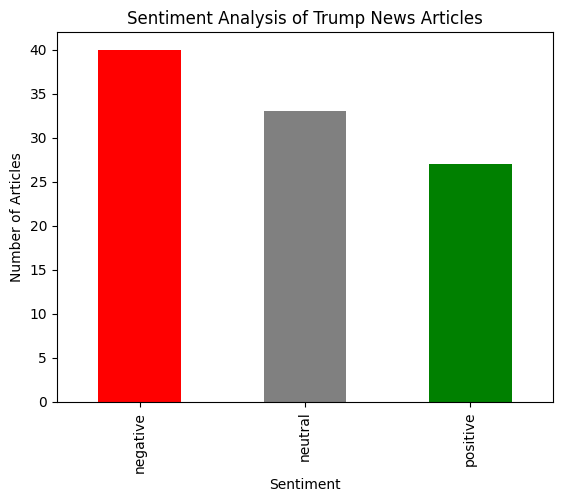

In [24]:
# Load the sentiment analysis results from the CSV file
df = pd.read_csv('/content/trump_news_sentiment.csv')

# Plot the sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
colors = {'positive': 'green', 'neutral': 'grey', 'negative': 'red'}
sentiment_counts.plot(kind='bar', color=[colors[key] for key in sentiment_counts.index])
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.title('Sentiment Analysis of Trump News Articles')
plt.show()


Showing the Colour Coded map based on the sentiment.

In [25]:
# Define colors for sentiments
colors = {'positive': 'green', 'neutral': 'grey', 'negative': 'red'}

# Initialize a folium map centered around the mean location
map_center = [df['latitude'].mean(), df['longitude'].mean()]
news_map = folium.Map(location=map_center, zoom_start=2)


# Apply sentiment analysis to the article descriptions
df['sentiment'] = df['description'].apply(lambda desc: get_sentiment_category(analyzer.polarity_scores(desc) if pd.notna(desc) else {'compound': 0}))

# Add markers to the map
for _, row in df.iterrows():
    if not pd.isna(row['latitude']) and not pd.isna(row['longitude']):
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=row['title'],
            tooltip=row['source_name'],
            icon=folium.Icon(color=colors[row['sentiment']])
        ).add_to(news_map)

# Display the map in the notebook
news_map

<ipython-input-25-35feb1a2276f>:19: UserWarning: color argument of Icon should be one of: {'blue', 'orange', 'darkblue', 'lightblue', 'lightgray', 'black', 'red', 'white', 'pink', 'beige', 'gray', 'purple', 'darkred', 'lightgreen', 'darkpurple', 'cadetblue', 'darkgreen', 'green', 'lightred'}.
  icon=folium.Icon(color=colors[row['sentiment']])
